In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import networkit as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
import phate

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from IPython.display import display, Math, Latex, Markdown
from tqdm.notebook import tqdm

from External.ICT.calculate_ICT import calculate_ICT
from External.clustering import centers, k_means_pp, ICT_clusters, cfilter, cassign
from External.generation import create_graph, find_backbone
from External.plotting import plot_points, plot_graph, no_intersections
from External.reweight import reweight_clusters
from External.data_loader import data_loader

from copy import deepcopy

# from External.create_k_nearest import patch_together

plt.style.use('standard.mplstyle')

In [5]:
# Hyperparameters
mode = "K_Nearest" # Graph construction mode
ICT_algorithm = "cluster_all"
metric = "euclidean" # metric for clustering

# Cluster rassignment
min_cluster_size = 12

In [6]:
position, labels, embedding = data_loader("eth_CC", True)
dtae_embedding, dtae_labels = data_loader("CC_DTAE_embedding", False)

number_of_nodes = len(position)

# calculate the clusters
pca = PCA(n_components=100).fit_transform(StandardScaler().fit_transform(position))

In [7]:
old_G, _ = create_graph(number_of_nodes, mode, position=pca)
old_G.indexEdges()

cluster_centers2 = centers(pca)
old_ICT = calculate_ICT(old_G, algorithm_type=ICT_algorithm, cluster_centers=cluster_centers2, zeros_stay_zeros=True, update_G=1.1)
old_ICT.indexEdges()

Final k: 11
sklearn is done: 30.463849306106567
My own part is done: 1.1904544830322266


create edgeId array:   0%|          | 0/138090 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/138090 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/13706 [00:00<?, ?it/s]

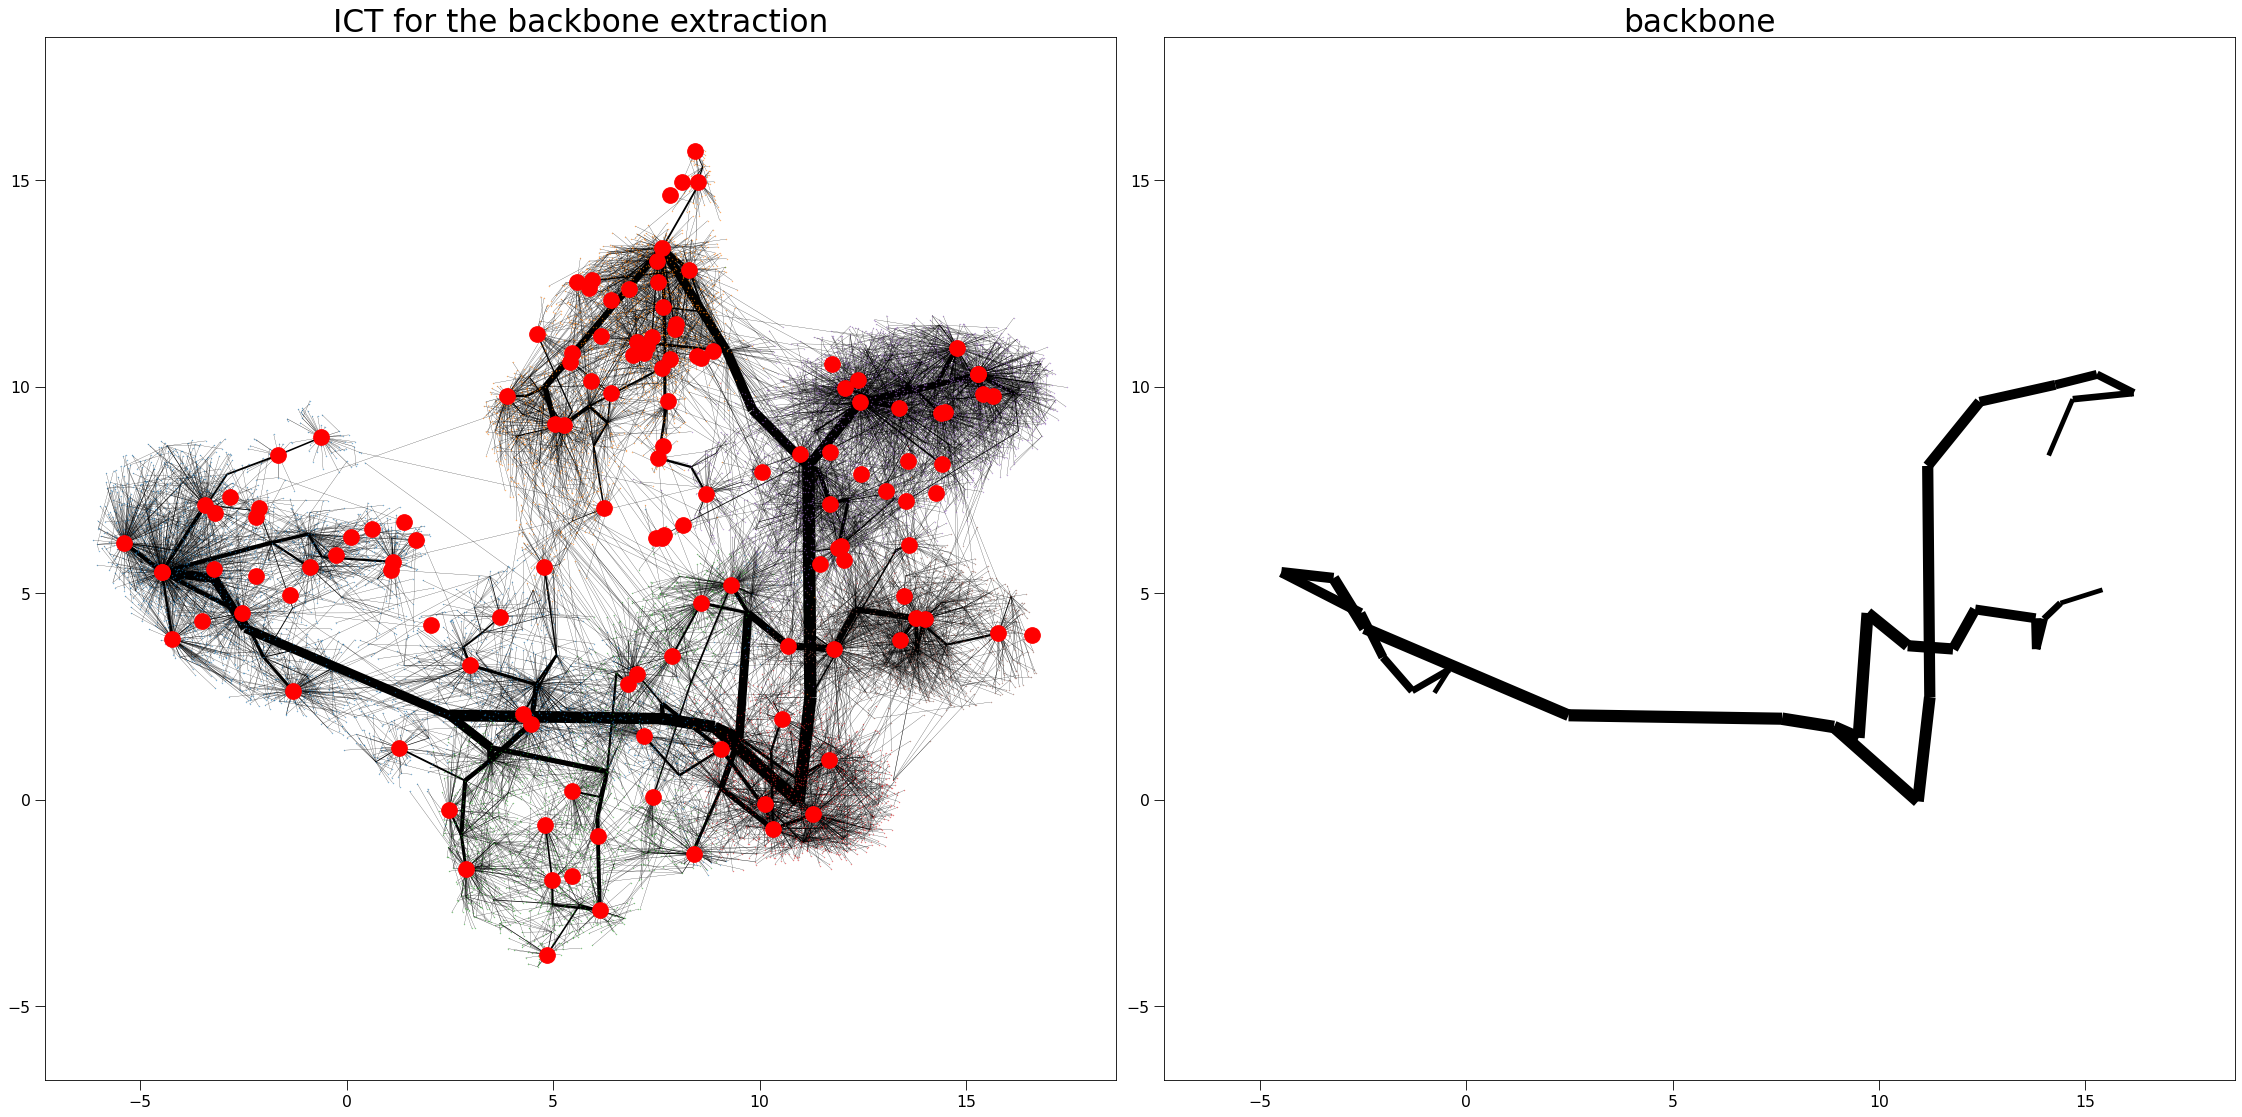

In [8]:
backbone, backbone_nodes = find_backbone(old_ICT, number_of_vertices=1)
backbone.indexEdges()

# Plot the ICT
fig, axs = plt.subplots(1, 2)
plot_points(embedding, f"", axs[0], labels=labels, node_size=0.5)
axs[0].get_legend().remove()
plot_graph(old_ICT, embedding, f"ICT for the backbone extraction", axs[0], cluster_centers=cluster_centers2, node_size=0)

plot_graph(backbone, embedding, f"backbone", axs[1], node_size=0)

plt.tight_layout()
plt.show()

sklearn is done: 19.16590929031372
My own part is done: 1.1856064796447754


create edgeId array:   0%|          | 0/138090 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/138090 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/13706 [00:00<?, ?it/s]

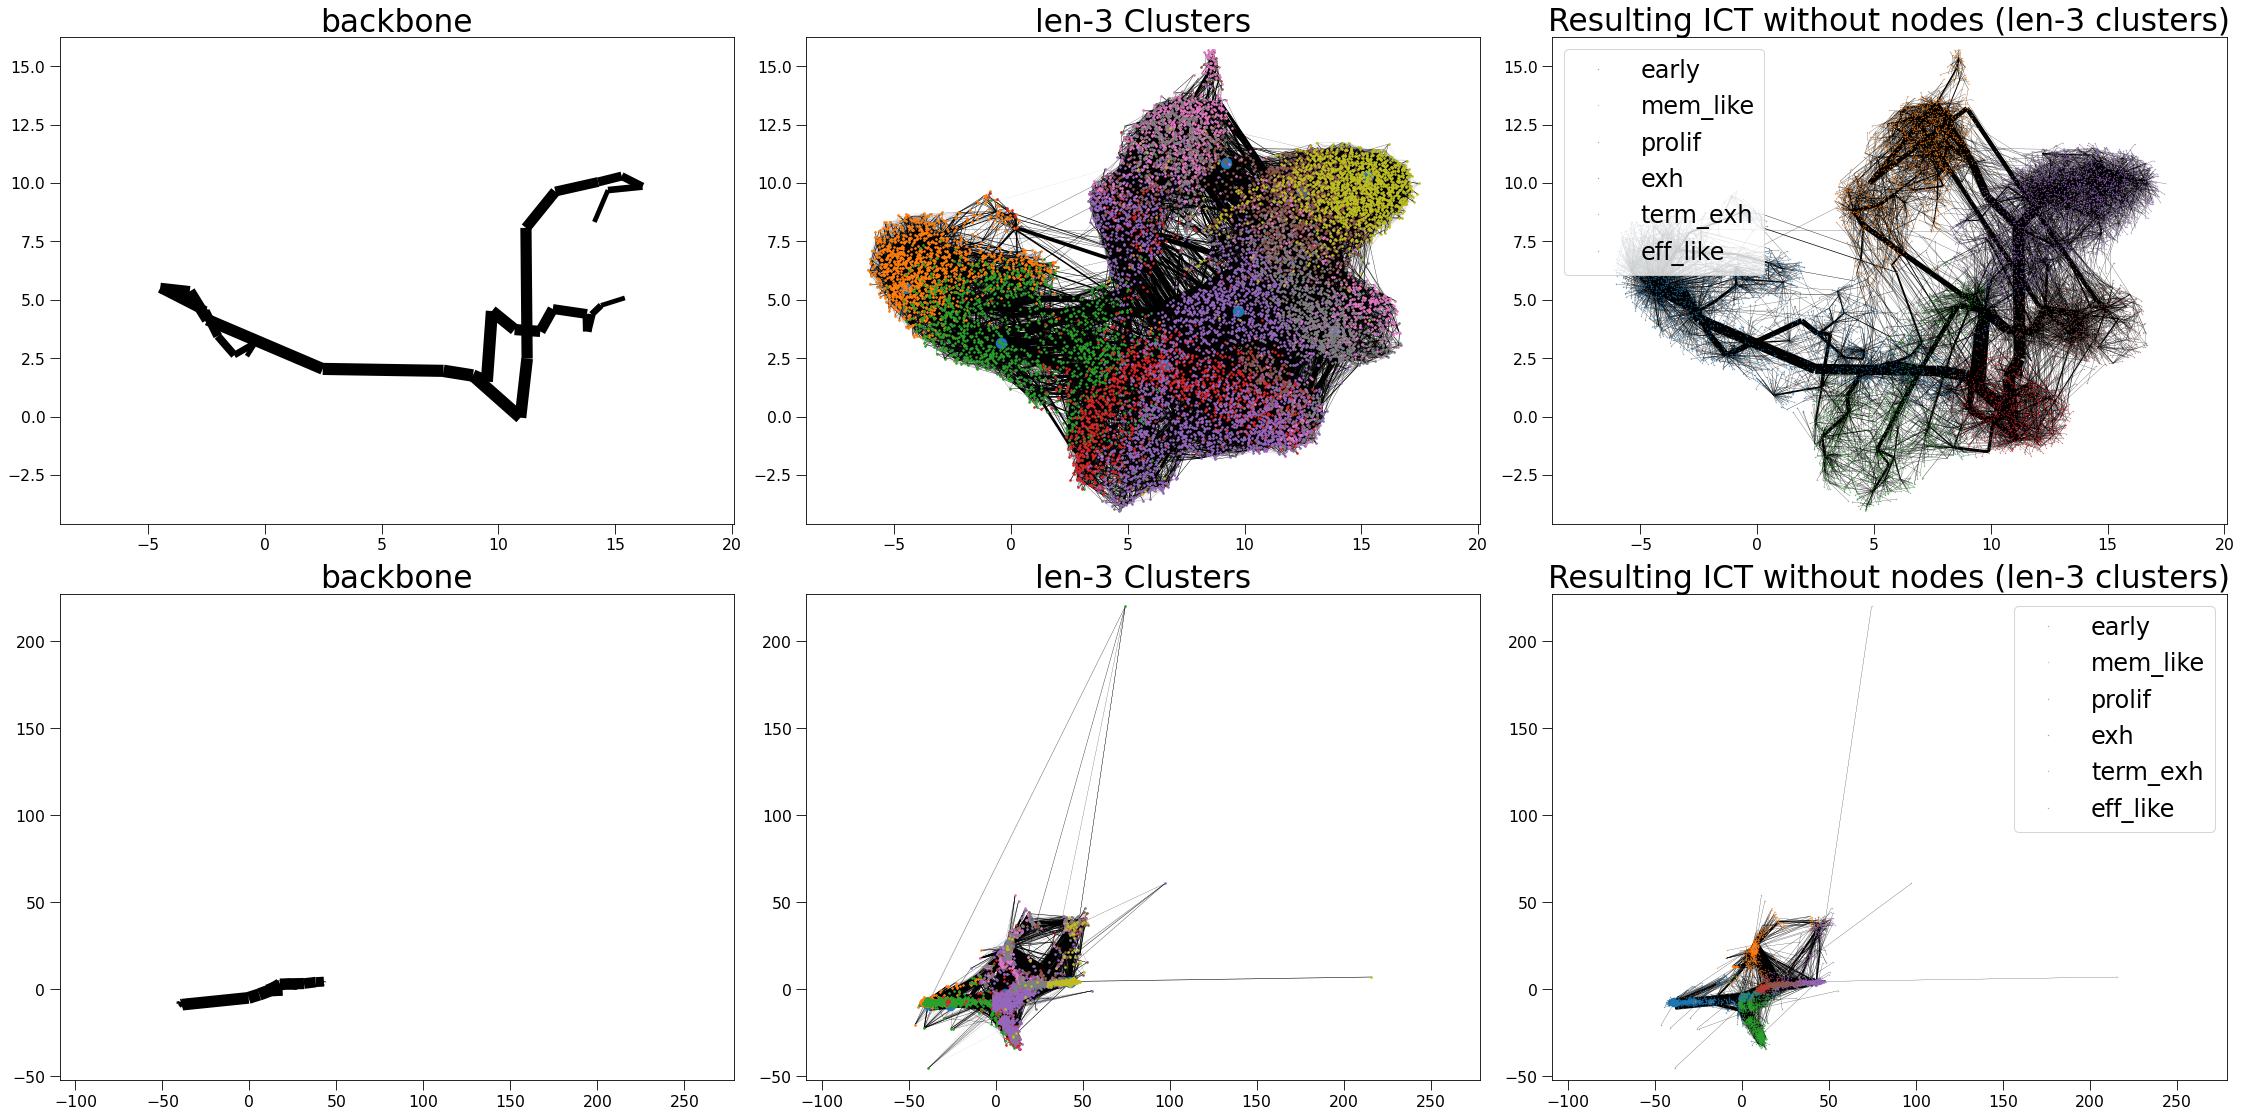

sklearn is done: 21.545974016189575
My own part is done: 1.0803027153015137


create edgeId array:   0%|          | 0/138090 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/138090 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/13706 [00:00<?, ?it/s]

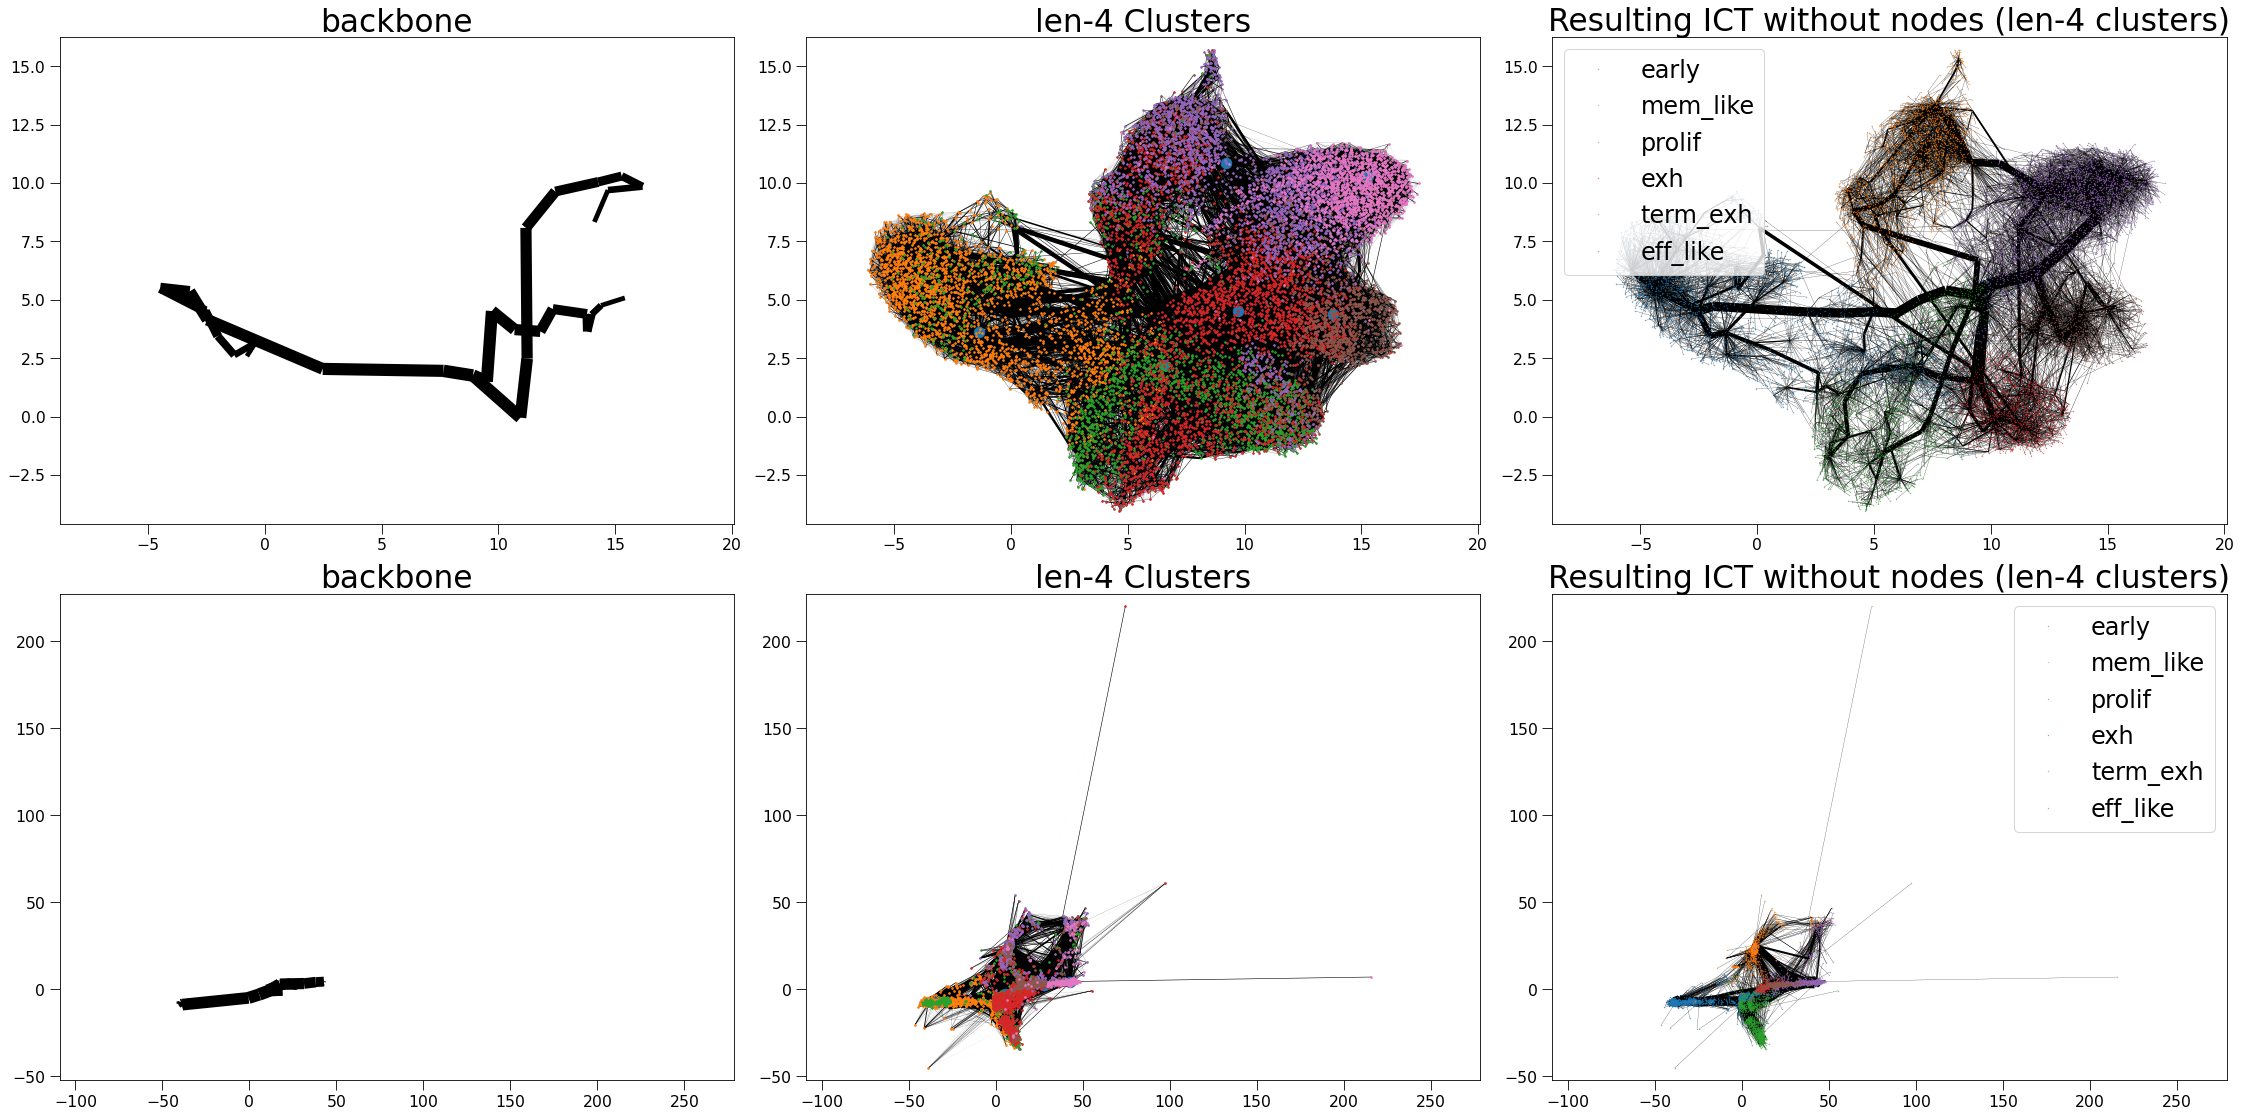

sklearn is done: 33.55993127822876
My own part is done: 1.017235279083252


create edgeId array:   0%|          | 0/138090 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/138090 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/13706 [00:00<?, ?it/s]

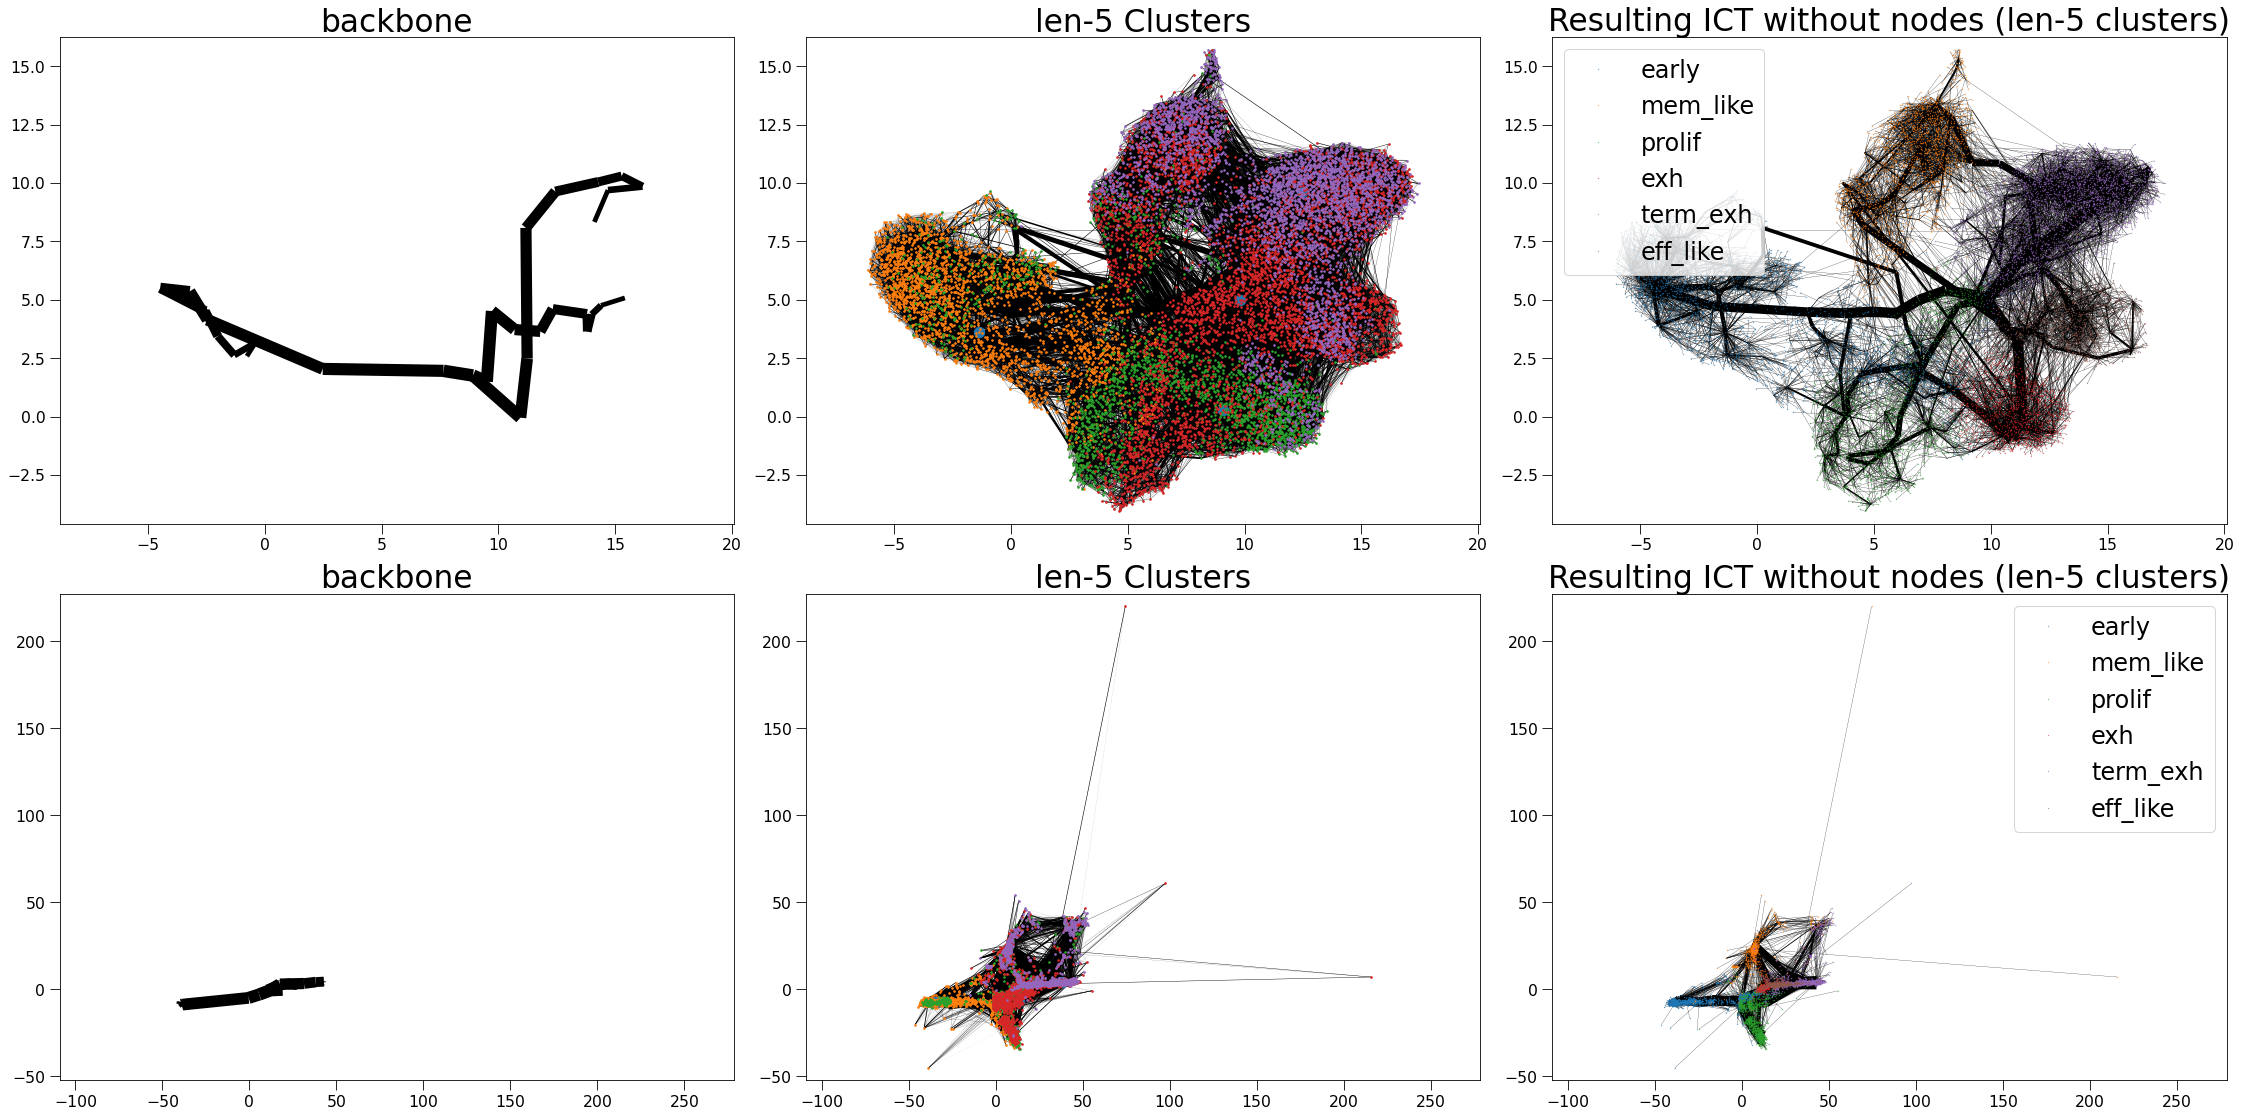

sklearn is done: 19.293288230895996
My own part is done: 1.0423476696014404


create edgeId array:   0%|          | 0/138090 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/138090 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/13706 [00:00<?, ?it/s]

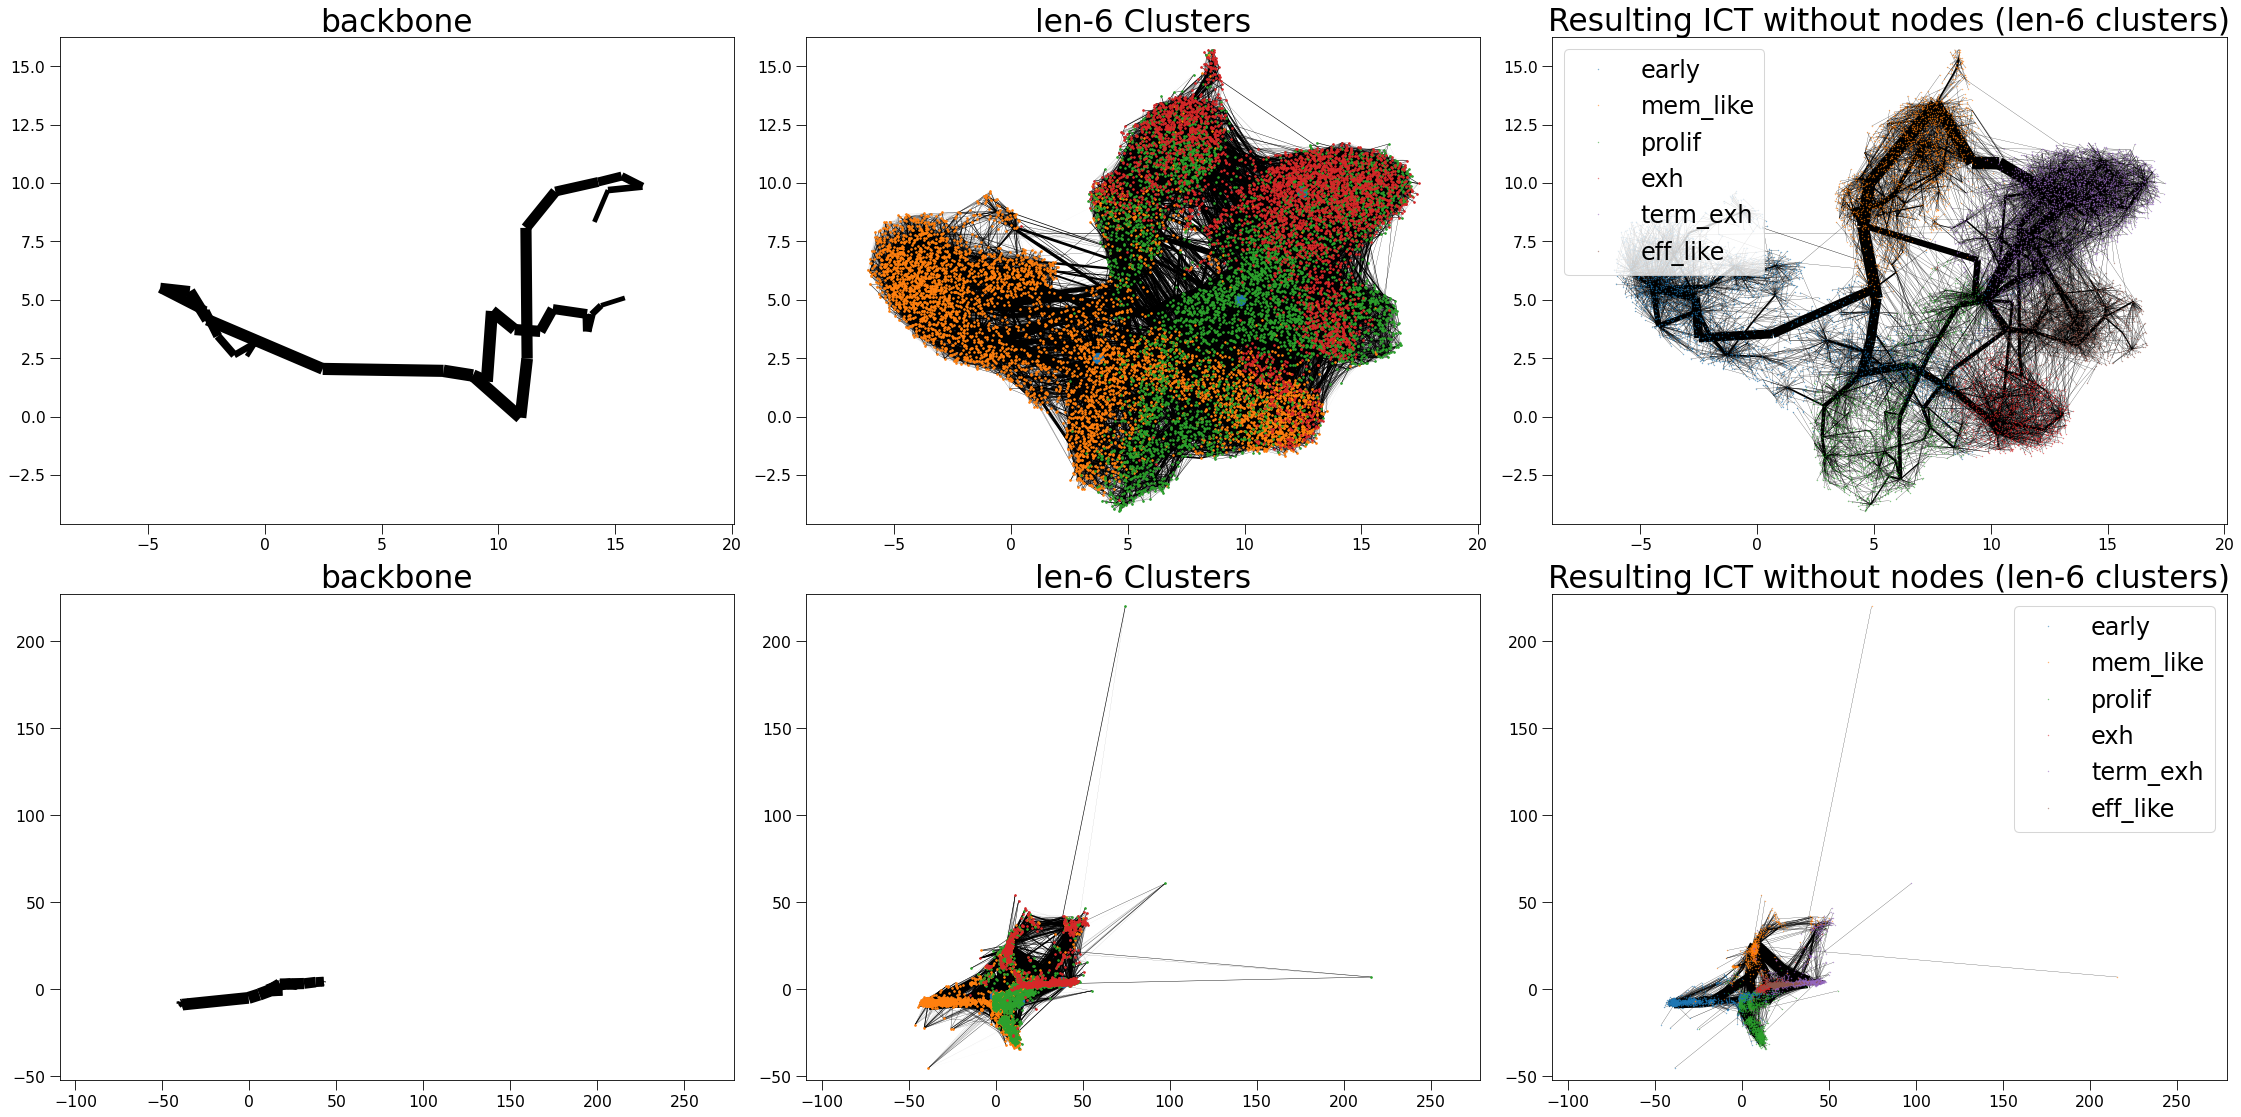

In [9]:
for k in range(3,7):
    
    G = deepcopy(old_G)
    cluster_centers, cluster_labels = ICT_clusters(old_ICT, pca, number_of_vertices=1, avg_cluster_len=k, log=False)

    cluster_centers, cluster_labels = cassign(cluster_centers, cluster_labels, pca, t=min_cluster_size)

    G = reweight_clusters(pca, G, cluster_centers, cluster_labels, min_scale = 0.3, max_scale=1.1)
    
    G.indexEdges()
    
    cluster_centers2 = centers(pca)
    
    ICT = calculate_ICT(G, algorithm_type=ICT_algorithm, cluster_centers=cluster_centers2, zeros_stay_zeros=True, update_G=1.1)
        
    ICT.indexEdges()
    
    # Plot the ICT
    fig, axs = plt.subplots(2, 3)
    
    plot_graph(backbone, embedding, f"backbone", axs[0,0], node_size=0)
    
    plot_graph(G, embedding, f"", axs[0,1], node_size=0)
    plot_points(embedding[cluster_centers], f"", axs[0,1], node_size=20)
    plot_points(embedding, f"len-{k} Clusters", axs[0,1], labels=np.array(cluster_labels), node_size=3)
    axs[0,1].get_legend().remove()
    
    
    plot_points(embedding, f"", axs[0,2], labels=labels, node_size=0.5)
    plot_graph(ICT, embedding, f"Resulting ICT without nodes (len-{k} clusters)", axs[0,2], node_size=0)
    name = str(k)
    
    
    
    
    
    plot_graph(backbone, dtae_embedding, f"backbone", axs[1,0], node_size=0)
    
    plot_graph(G, dtae_embedding, f"", axs[1,1], node_size=0)
    plot_points(dtae_embedding[cluster_centers], f"", axs[1,1], node_size=20)
    plot_points(dtae_embedding, f"len-{k} Clusters", axs[1,1], labels=np.array(cluster_labels), node_size=3)
    axs[1,1].get_legend().remove()
    
    
    plot_points(dtae_embedding, f"", axs[1,2], labels=dtae_labels, node_size=0.5)
    plot_graph(ICT, dtae_embedding, f"Resulting ICT without nodes (len-{k} clusters)", axs[1,2], node_size=0)
    name = str(k)
    
    
    plt.tight_layout()
    plt.savefig(f"Output/Pancreas/1-Vertex-pca/" + name.zfill(5) + ".png")
    plt.show()

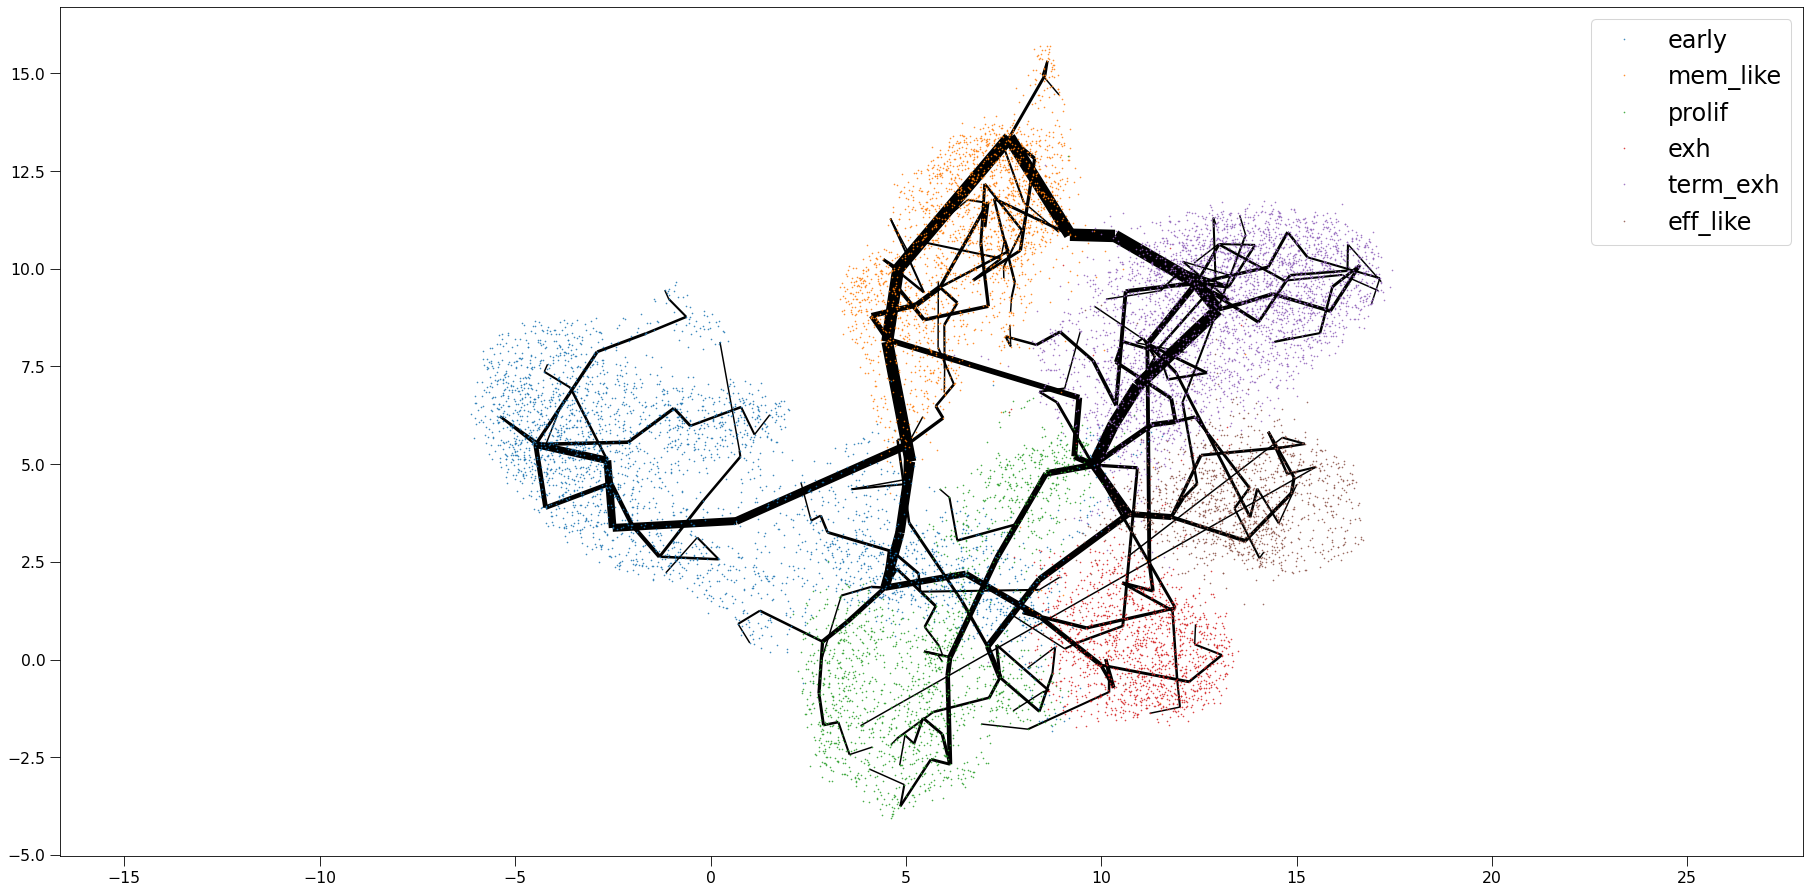

In [23]:
fig, ax = plt.subplots(1)
backbone = find_backbone(ICT, 50)[0]
backbone.indexEdges()
plot_graph(backbone, embedding, f"Resulting ICT without nodes (len-{k} clusters)", ax, node_size=0)
plot_points(embedding, f"", ax, labels=dtae_labels, node_size=1)